# CNN for seismic facies classification

## Imports and dataset loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import k3d
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from livelossplot.keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.python.client import device_lib
from ipywidgets import interact, widgets

import src

Using TensorFlow backend.


In [3]:
with h5py.File('../data/interim/stanford6_truncated_rgb.h5', 'r') as dataset:
    x_train_original = np.array(dataset['train/X'])
    y_train_original = np.array(dataset['train/Y'])
    x_test_original = np.array(dataset['test/X'])
    y_test_original = np.array(dataset['test/Y'])

classnames = {
    0: 'Floodplain',
    1: 'Pointbar',
    2: 'Channel',
    3: 'Boundary',
}    
    
m = x_train_original.shape[0]
num_classes = 4

## Dataset visualization

Training class frequencies: {0: 563, 1: 86, 2: 171, 3: 60}
Test class frequencies: {0: 1119304, 1: 225860, 2: 309370, 3: 115234}


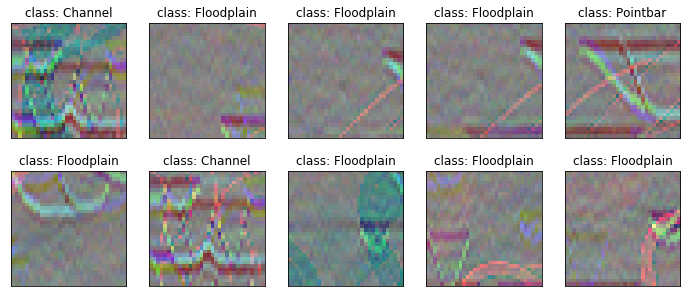

In [4]:
frequencies = src.class_frequency(y_train_original, num_classes)
print(f'Training class frequencies: {frequencies}')
print(f'Test class frequencies: {src.class_frequency(y_test_original, num_classes)}')

nrows, ncols = 2, 5
idx = np.random.choice(m, nrows * ncols)
fig = plt.figure(figsize=(12, 5))
for i in range(1, nrows * ncols +1):
    fig.add_subplot(nrows, ncols, i)
    plt.imshow(x_train_original[idx[i-1]])
    plt.title(f'class: {classnames[y_train_original[idx[i-1]][0]]}')
    plt.xticks([])
    plt.yticks([])   

## Dataset normalization

In [5]:
x_train = x_train_original / 255
y_train = keras.utils.to_categorical(y_train_original, num_classes)
x_test = x_test_original / 255
y_test = keras.utils.to_categorical(y_test_original, num_classes)

## The model

In [6]:
input_shape = x_train.shape[1:]

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activat

## Model training

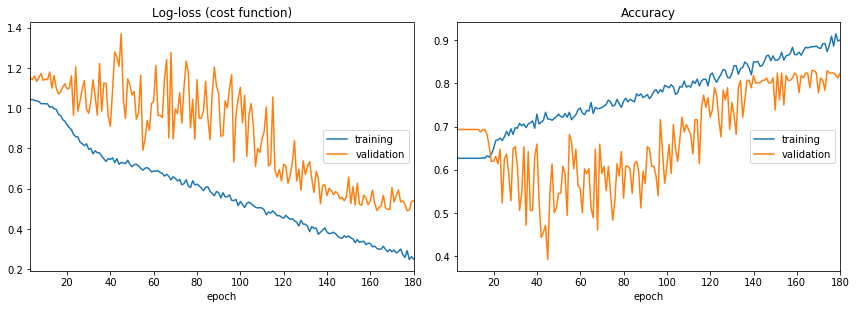

Log-loss (cost function):
training   (min:    0.249, max:    1.126, cur:    0.252)
validation (min:    0.491, max:    1.369, cur:    0.541)

Accuracy:
training   (min:    0.599, max:    0.915, cur:    0.901)
validation (min:    0.392, max:    0.830, cur:    0.824)


In [7]:
batch_size = 32
epochs = 180

weights = [m / v for v in frequencies.values()]

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    shuffle=True,
    callbacks=[PlotLossesCallback()],
    class_weight=weights
)

## Model validation

1769768/1769768 [==============================] - 85s 48us/step
Test loss: 0.6234768368528667
Test acc: 0.7410615402696851
F1-score: 0.7413491178054266


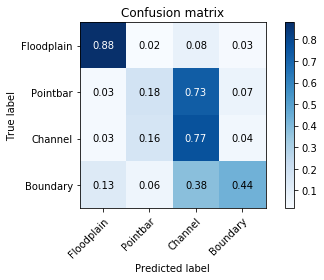

In [8]:
scores = model.evaluate(x_test, y_test, verbose=1)
for i, score in enumerate(scores):
    print(f'Test {model.metrics_names[i]}: {score}')
    
predict_class = np.argmax(model.predict(x_test), axis=1)
print(f'F1-score: {f1_score(y_test_original, predict_class, average="weighted")}')
matrix = confusion_matrix(y_test_original, predict_class)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
      
src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")

In [9]:
def plot_section(z=0):
    plt.subplot(121)
    plt.imshow(y_test_original.reshape(119, 169, 88)[:,:,z].T)
    plt.subplot(122)
    plt.imshow(predict_class.reshape(119, 169, 88)[:,:,z].T)
    
interact(plot_section, z=widgets.IntSlider(min=0,max=87,step=1,value=0))

interactive(children=(IntSlider(value=0, description='z', max=87), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_section(z=0)>

In [10]:
color_map = (0x3A528B, 0x20908C, 0xFDE724)

plot = k3d.plot()
obj = k3d.voxels(predict_class.reshape(119, 169, 88).T, color_map, compression_level=1)
plot += obj
plot.display()

C:\Users\Arthur\Anaconda3\lib\site-packages\traittypes\traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint8". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()